In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from Adversary import Adversary, Problem
from Solvers import adv_solver, partial, span_solver
from Examples import threshold_k
from ElementDistinctness import ED
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =200
import cvxpy as cp
from cvxpy.atoms.affine.hstack import hstack
from cvxpy.atoms.affine.vstack import vstack

In [4]:
n = 3
k = 3
prob =  ED(n)


[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


In [5]:
def disagree_mask(problem, yes, no, d,  mat_size):
    # yes = problem.yes_instances[yes_index]
    # no = problem.no_instancesl[no_index]
    yes_index = problem.instance_to_index[yes]
    no_index = problem.instance_to_index[no]
    mask = []
    pair_mat = np.zeros((n, n))
    for i in range(n):
        if yes[i] != no[i]:
            pair_mat[i,i]= 1
    pair_mat = np.kron(np.eye(d), pair_mat)
    for i in range(problem.len):
        mask.append([
            np.zeros((n*d, n*d)) if i != no_index or j != yes_index else pair_mat for j in range(problem.len)
        ])
        
    mask = np.block(mask)
    return mask + mask.T

def diag_mask(problem, instance, d, mat_size):
    instance_mask = np.eye(problem.n * d)
    mask = np.zeros((problem.len, problem.len))
    index = problem.instance_to_index[instance]
    mask[index][index] = 1
    mask = np.kron(mask, instance_mask)
    return mask + mask.T

def diag_vect(problem, instance, d, mat_size):
    instance_mask = np.ones((problem.n * d, 1))
    instance_vect = np.zeros((problem.len, 1))
    instance_vect[problem.instance_to_index[instance]] = 1
    return np.kron(instance_vect, instance_mask)

def bmat(block_lists):
    """Constructs a block matrix.

    Takes a list of lists. Each internal list is stacked horizontally.
    The internal lists are stacked vertically.

    Parameters
    ----------
    block_lists : list of lists
        The blocks of the block matrix.

    Return
    ------
    CVXPY expression
        The CVXPY expression representing the block matrix.
    """
    row_blocks = [hstack(blocks) for blocks in block_lists]
    return vstack(row_blocks)

def space_span_solver(problem, d):
    lang_size = problem.yes_len + problem.no_len
    n = problem.n
    mat_size = lang_size * n * d + 2
    P = cp.Variable((mat_size, mat_size), symmetric=True)
    p = cp.Variable((mat_size, 1))
    C = np.zeros((mat_size, mat_size))
    C[-1, -1] = -1
    C[-2, -2] = 2
    # x = cp.Variable((mat_size, 1))
    print(p)
    block = bmat([
        [np.ones((1,1)), p.T],
        [p, P]
    ])
    
    constraints = [block >> 0]
    constraints.append(
        cp.trace(P) <= n * mat_size
    )
    
    for yes in problem.yes_instances:
        for no in problem.no_instances:
            small_mask = disagree_mask(problem, yes, no, d, mat_size)
            mask = np.zeros((mat_size, mat_size))
            mask[:-2, :-2] = small_mask
            # print(mask)
            constraints += [
                cp.scalar_product(mask, P) == 1 
            ]
    
    for instance in problem.instances:
        small_mask = diag_mask(problem, instance, d, mat_size)
        mask = np.zeros((mat_size, mat_size))
        mask[:-2, :-2] = small_mask 
        mask[-1, -1] = -1
        constraints += [
            cp.scalar_product(mask, P) <= 0
        ]
        mask[-2, -2] = -1
        mask[-1, -1] = 0
        constraints += [
            cp.scalar_product(mask, P) <= 0
        ]
    mask1 = np.zeros((mat_size,mat_size))
    mask1[-1,-1] = 1
    mask2 = np.zeros((mat_size, mat_size))
    mask2[-2,-2] = -1
    constraints.append(cp.scalar_product(mask1+mask2, P) == 0)    

    c = np.zeros(mat_size)
    c[-2] = 0
    c[-1] = -1
    opt_prob = cp.Problem(cp.Minimize(cp.scalar_product(C, P)), constraints)
    opt_prob.solve(solver='SCS', verbose=True)
    return opt_prob.value, P.value

d = 1
v, P = space_span_solver(prob, d)
print(P)
v, X = span_solver(prob, {'solver': 'SCS', 'verbose': True})

var2
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Aug 05 04:45:10 PM: Your problem has 5550 variables, 159 constraints, and 0 parameters.
(CVXPY) Aug 05 04:45:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 05 04:45:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 05 04:45:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 05 04:45:10 PM: Compiling problem (target solver=SCS).
(CVXPY) Aug 05 04:45:10 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStu

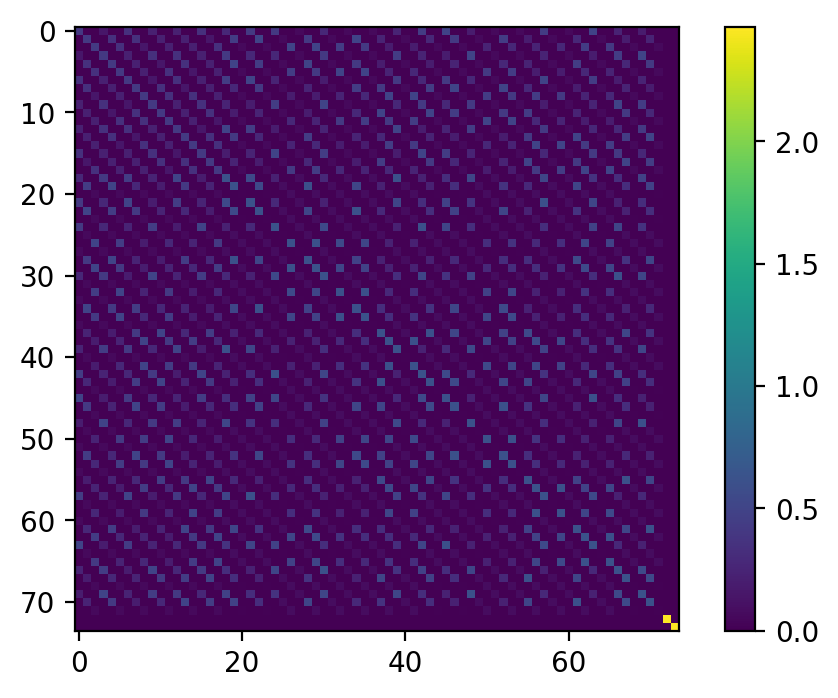

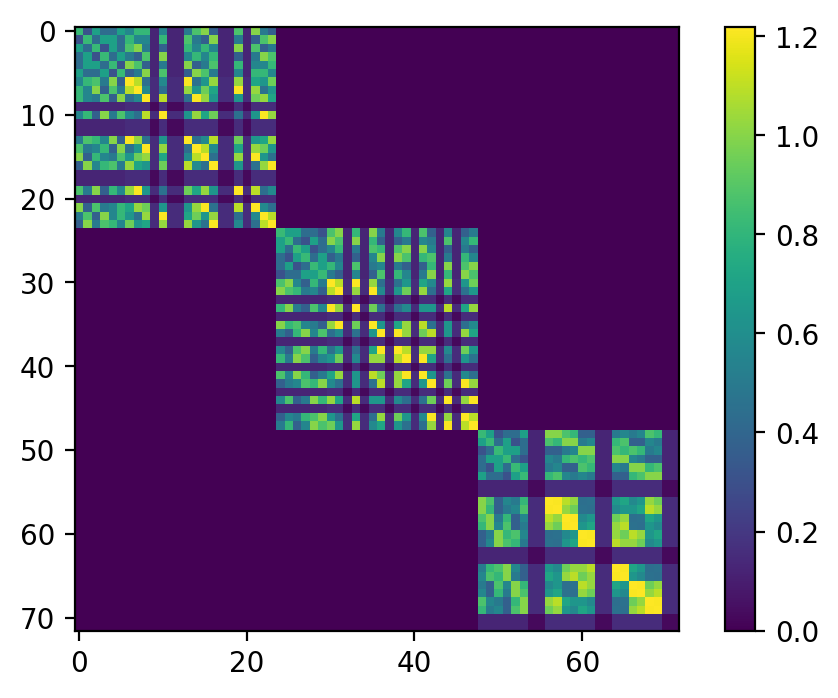

{0.4113983927, 0.0, 0.3469991308, 0.2794565314, 0.406844498, 0.2499970332, 0.4999999988, 0.2864551917, 0.2234686676, 0.5469244976, 2.4683835466, 2.4683835464, 0.0773508436, 0.6099142984, 0.3200792561, 0.4363023445, 0.4751848913, 0.0636996129, 0.5133004331, 0.3581947979, 0.1537709649, 0.2181803535, 0.1863030499, 0.2279601449, 0.0636976575, 0.0143620453, 0.0636999165, 0.0143587685, 0.6054195443}
74


In [10]:
plt.imshow(P)
plt.colorbar()
plt.show()
plt.imshow(X)
plt.colorbar()
plt.show()
print(set(np.round(P.flatten(), 10)))
print(np.linalg.matrix_rank(np.round(P, 6)))

In [63]:
a = np.array([[1,2], [3,4]])
np.block([[a, 1],[1,1]])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 2 and the array at index 1 has size 1